## Task 3. 

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import random
from PIL import Image
import imageio
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [2]:
# Define paths
DATASET_PATH = "./lfw/"
ATTRIBUTES_PATH = "./lfw_attributes.txt"

In [3]:
# Fetch the dataset
def fetch_dataset(dx=80, dy=80, dimx=45, dimy=45):
    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])

    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath, fname)
                photo_id = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person': person_id, 'imagenum': photo_number, 'photo_path': fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs, photo_ids, on=('person', 'imagenum'))

    assert len(df) == len(df_attrs), "Lost some data when merging dataframes"

    all_photos = df['photo_path'].apply(imageio.imread) \
        .apply(lambda img: img[dy:-dy, dx:-dx]) \
        .apply(lambda img: np.array(Image.fromarray(img).resize([dimx, dimy])))

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path", "person", "imagenum"], axis=1)

    return all_photos, all_attrs

# Load the dataset
data, attrs = fetch_dataset()

In [4]:
# Constants
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
N_CHANNELS = 3

# Split data into training and validation sets
data = np.array(data / 255, dtype='float32')
X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)

In [5]:
# Define the Autoencoder architecture
class AutoencoderCNN(nn.Module):
    def __init__(self):
        super(AutoencoderCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=32, kernel_size=5, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=5, stride=2),
            nn.ReLU()
        )

    def encode(self, z):
        return self.encoder(z)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return encoded, decoded

In [6]:
# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model_auto = AutoencoderCNN().to(device)

# Function to get batches of data
def get_batch(data, batch_size=64):
    total_len = data.shape[0]
    for i in range(0, total_len, batch_size):
        yield data[i:min(i + batch_size, total_len)]

# Function to plot image galleries
def plot_gallery(images, h, w, n_row=3, n_col=6, with_title=False, titles=[]):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest'))
            if with_title:
                plt.title(titles[i])
            plt.xticks(())
            plt.yticks(())
        except:
            pass

# Function to fit one epoch
def fit_epoch(model, train_x, criterion, optimizer, batch_size, is_cnn=True):
    running_loss = 0.0
    processed_data = 0

    for inputs in get_batch(train_x, batch_size):
        if not is_cnn:
            inputs = inputs.view(-1, 45 * 45 * 3)
        inputs = inputs.to(device)

        optimizer.zero_grad()

        encoder, decoder = model(inputs)

        if not is_cnn:
            outputs = decoder.view(-1, 45 * 45 * 3)
        else:
            outputs = decoder.permute(0, 2, 3, 1)

        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.shape[0]
        processed_data += inputs.shape[0]

    train_loss = running_loss / processed_data
    return train_loss

# Function to evaluate one epoch
def eval_epoch(model, x_val, criterion, is_cnn=True):
    running_loss = 0.0
    processed_data = 0
    model.eval()

    for inputs in get_batch(x_val):
        if not is_cnn:
            inputs = inputs.view(-1, 45 * 45 * 3)
        inputs = inputs.to(device)

        with torch.set_grad_enabled(False):
            encoder, decoder = model(inputs)

            if not is_cnn:
                outputs = decoder.view(-1, 45 * 45 * 3)
            else:
                outputs = decoder.permute(0, 2, 3, 1)

            loss = criterion(outputs, inputs)
            running_loss += loss.item() * inputs.shape[0]
            processed_data += inputs.shape[0]

    val_loss = running_loss / processed_data

    # Draw an example
    with torch.set_grad_enabled(False):
        pic = x_val[3]
        if not is_cnn:
            pic_input = pic.view(-1, 45 * 45 * 3)
        else:
            pic_input = torch.FloatTensor(pic.unsqueeze(0))
        pic_input = pic_input.to(device)
        encoder, decoder = model(pic_input)
        if not is_cnn:
            pic_output = decoder.view(-1, 45 * 45 * 3).squeeze()
        else:
            pic_output = decoder.permute(0, 2, 3, 1)
        pic_output = pic_output.to("cpu")
        pic_input = pic_input.to("cpu")

    return val_loss

# Training function
def train_model(train_x, val_x, model, epochs=10, batch_size=32, is_cnn=True):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    history = []

    for epoch in range(epochs):
        train_loss = fit_epoch(model, train_x, criterion, optimizer, batch_size, is_cnn)
        val_loss = eval_epoch(model, val_x, criterion, is_cnn)
        print(f"Epoch {epoch+1}: Training Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}")

        history.append((train_loss, val_loss))

    return history

# Train the model
training_history = train_model(X_train, X_val, model_auto, epochs=100, batch_size=32, is_cnn=True)


Epoch 1: Training Loss = 0.0215, Validation Loss = 0.0086
Epoch 2: Training Loss = 0.0069, Validation Loss = 0.0059
Epoch 3: Training Loss = 0.0054, Validation Loss = 0.0052
Epoch 4: Training Loss = 0.0048, Validation Loss = 0.0048
Epoch 5: Training Loss = 0.0045, Validation Loss = 0.0043
Epoch 6: Training Loss = 0.0042, Validation Loss = 0.0041
Epoch 7: Training Loss = 0.0040, Validation Loss = 0.0040
Epoch 8: Training Loss = 0.0039, Validation Loss = 0.0038
Epoch 9: Training Loss = 0.0038, Validation Loss = 0.0036
Epoch 10: Training Loss = 0.0037, Validation Loss = 0.0037
Epoch 11: Training Loss = 0.0036, Validation Loss = 0.0035
Epoch 12: Training Loss = 0.0035, Validation Loss = 0.0035
Epoch 13: Training Loss = 0.0035, Validation Loss = 0.0034
Epoch 14: Training Loss = 0.0034, Validation Loss = 0.0034
Epoch 15: Training Loss = 0.0034, Validation Loss = 0.0034
Epoch 16: Training Loss = 0.0033, Validation Loss = 0.0034
Epoch 17: Training Loss = 0.0033, Validation Loss = 0.0032
Epoch 

[]

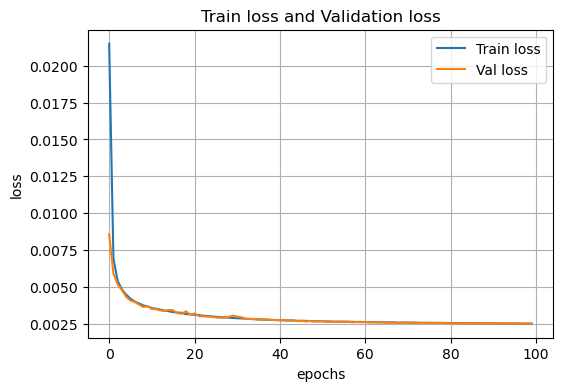

In [7]:
train_loss, val_loss = zip(*training_history)
plt.figure(figsize=(6,4))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title('Train loss and Validation loss')
plt.grid()
plt.plot()

### Define the features to make vectors from the latent space

In [8]:
smile_ids = attrs['Smiling'].sort_values(ascending=False).iloc[100:125].index.values
smile_data = data[smile_ids]

no_smile_ids = attrs['Smiling'].sort_values(ascending=True).head(25).index.values
no_smile_data = data[no_smile_ids]

beard_ids = attrs['No Beard'].sort_values(ascending=True).head(25).index.values
beard_data = data[beard_ids]

shaven_ids = attrs['No Beard'].sort_values(ascending=False).head(25).index.values
shaven_data = data[shaven_ids]

## 1. Encode to the latent space
## 2. Decode from it

In [9]:
def to_latent(pic):
    with torch.no_grad():
        inputs = torch.FloatTensor(pic).permute(0, 3, 1, 2)  # Reshape to [batch_size, channels, height, width]
        inputs = inputs.to(device)
        model_auto.eval()
        output = model_auto.encode(inputs)        
        return output

def from_latent(vec):
    with torch.no_grad():
        inputs = vec.to(device)
        model_auto.eval()
        output = model_auto.decode(inputs)        
        return output

In [10]:
smile_latent = to_latent(smile_data).mean(axis=0)
no_smile_latent = to_latent(no_smile_data).mean(axis=0)
beard_latent = to_latent(beard_data).mean(axis=0)

smile_vec = smile_latent-no_smile_latent
beard_vec = beard_latent - smile_latent

def smile_shaven(ids):
    for id in ids:
        pic = data[id:id+1]
        
        if isinstance(pic, torch.Tensor):
            pic_np = pic.cpu().detach().numpy().squeeze()
        else: 
            pic_np = pic.squeeze()
        
        latent_vec = to_latent(pic)
        latent_vec[0] = latent_vec[0] + smile_vec - beard_vec
        pic_output = from_latent(latent_vec)
        # break
        if isinstance(pic_output, torch.Tensor):
            pic_output_np = pic_output.cpu().detach().numpy().squeeze()
            pic_output_np = pic_output_np.transpose(1,2,0)
        else:
            pic_output_np = pic_output.squeeze()

        plt.figure(figsize=(4,2))
        plt.subplot(1,2,1)
        plt.imshow(pic_np)
        plt.title ("Original")
        plt.axis('off')
        
        plt.subplot(1,2,2)
        plt.imshow(pic_output_np)
        plt.title ("Smiled + No Beard")
        plt.axis('off')

In [11]:
beard_ids

array([ 4582,  2767,  5133,  1482, 11153,   768,  3750,  6746,   960,
        1481,  3451,   110,  9965,  3257,  6844,  4586,  3598,    58,
        4579,  9330,  8155,   151,   350,  8620,  4583])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

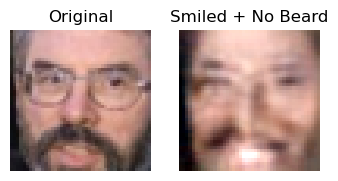

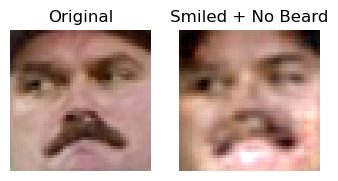

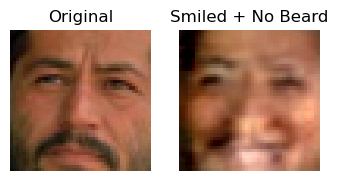

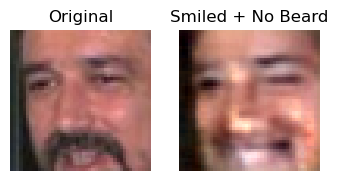

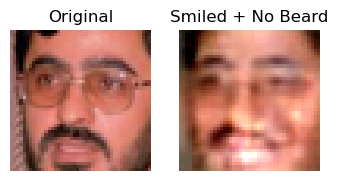

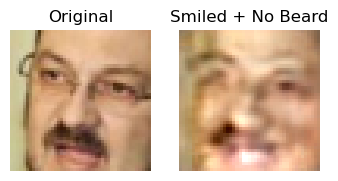

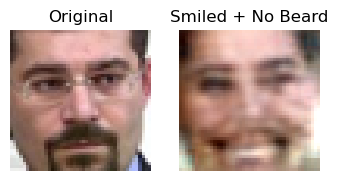

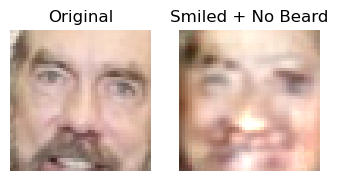

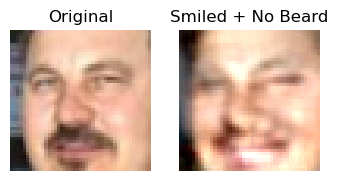

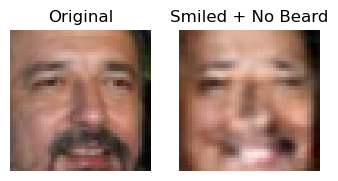

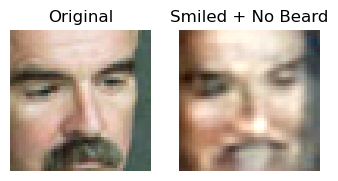

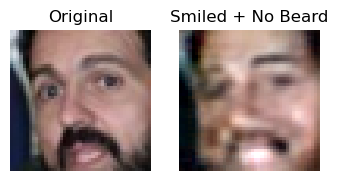

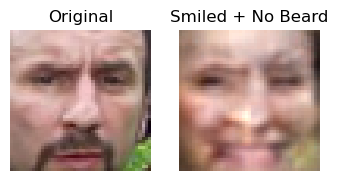

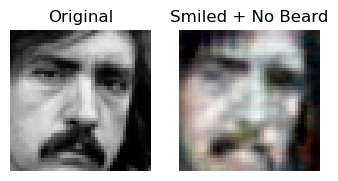

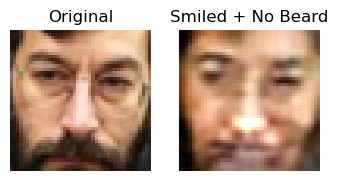

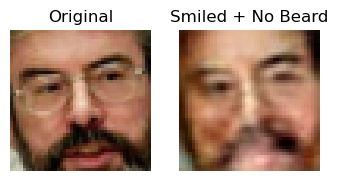

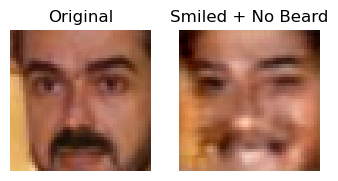

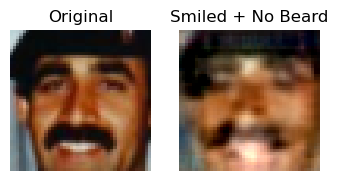

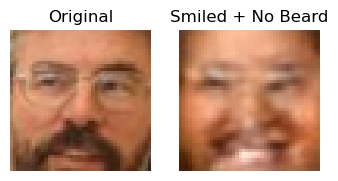

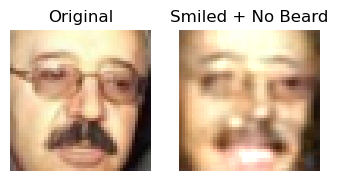

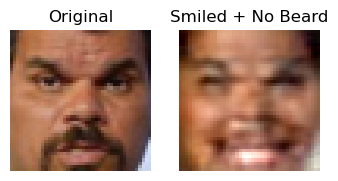

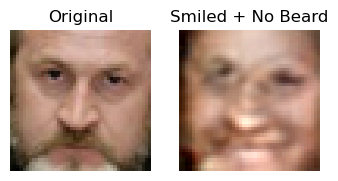

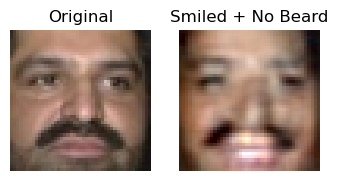

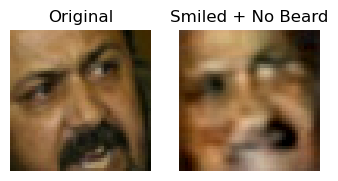

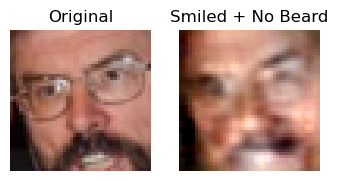

In [12]:
smile_shaven(beard_ids)

## Results:



Visually the smile is successfully applied, 
but the mustaches are other confused with the lips

Increasing the kernel size gives much better results